## Some Exploratory Data Analysis


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data import *

# remove all columns except the first one for sample_submission
sample_submission = sample_submission.iloc[:, 0]

### Let's start with Subjective Poverty first


(5337, 11)


/var/folders/92/lv5lwsyj6pq0h_8d0gm14m680000gn/T/ipykernel_62505/4154581412.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(range(1, 11)))


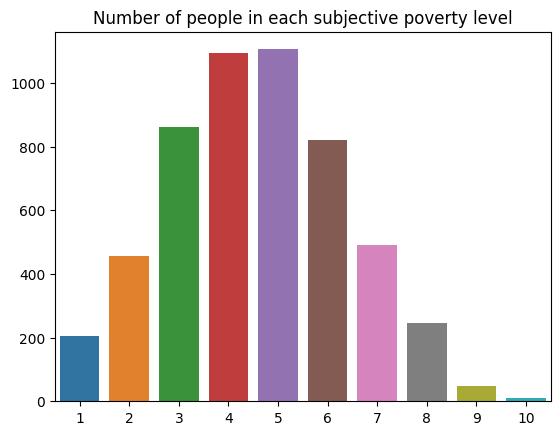

In [2]:
print(pov_train.shape)

# a very normal like distribution!
ax = sns.barplot(pov_train.iloc[:, 1:], estimator="sum", errorbar=None)
ax.set_xticklabels(list(range(1, 11)))
plt.title("Number of people in each subjective poverty level")
plt.show()

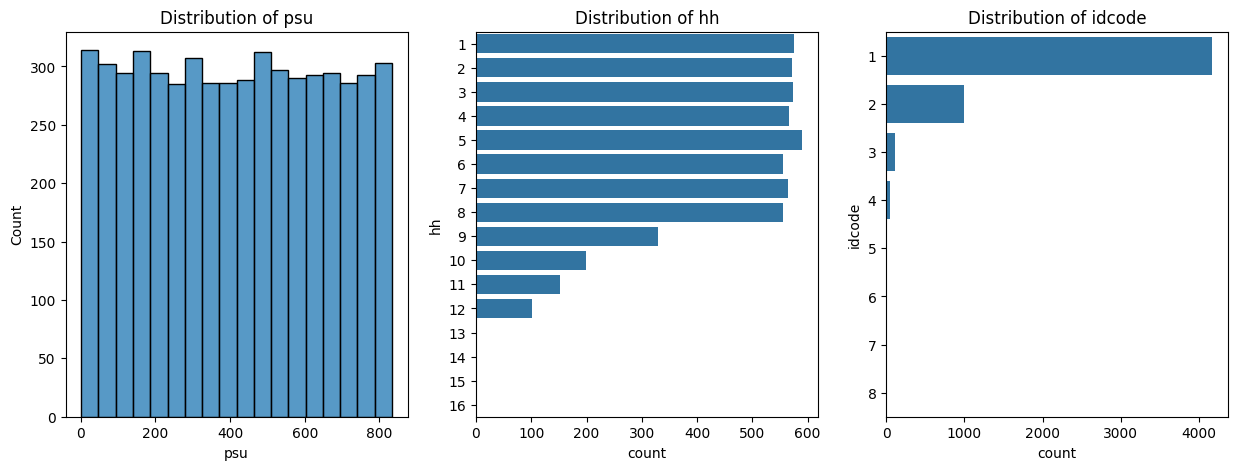

In [3]:
pov_train[["psu", "hh", "idcode"]] = (
    pov_train["psu_hh_idcode"].str.split("_", expand=True).astype(int)
)
# plot the distribution of psu, hh, and idcode
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(pov_train["psu"], ax=ax[0])
ax[0].set_title("Distribution of psu")
sns.countplot(pov_train["hh"].astype(str), ax=ax[1], order=list(range(1, 17)))
ax[1].set_title("Distribution of hh")
sns.countplot(pov_train["idcode"].astype(str), ax=ax[2], order=list(range(1, 9)))
ax[2].set_title("Distribution of idcode")
plt.show()

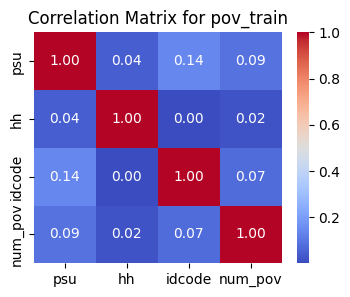

In [4]:
# we might as well convert it to a range of 1-10
# I also tried with just the classes themselves, but not much difference in the correlation matrix
pov_train["num_pov"] = (
    pov_train.iloc[:, 1:11].idxmax(axis=1).str.split("_").str[-1].astype(int)
)
# Calculate the correlation matrix
corr = pov_train[["psu", "hh", "idcode", "num_pov"]].corr()

# Generate a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for pov_train")
plt.show()

### Then Education data


In [5]:
edu_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22406 entries, 0 to 22405
Data columns (total 69 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   psu     22406 non-null  int64  
 1   hh      22406 non-null  int64  
 2   idcode  22406 non-null  int64  
 3   q01     22406 non-null  int64  
 4   q02     22406 non-null  int64  
 5   q03     22406 non-null  int64  
 6   q04     21513 non-null  float64
 7   q05     21513 non-null  float64
 8   q06     21513 non-null  float64
 9   q07     21513 non-null  float64
 10  Q08     21513 non-null  float64
 11  Q09     5565 non-null   float64
 12  Q10     39 non-null     float64
 13  Q11     15948 non-null  float64
 14  Q12     5526 non-null   float64
 15  Q13     5526 non-null   float64
 16  Q14     21513 non-null  float64
 17  Q15     5625 non-null   float64
 18  Q16     35 non-null     float64
 19  Q17     15888 non-null  float64
 20  Q18     15888 non-null  float64
 21  Q19     15923 non-null  float64
 22

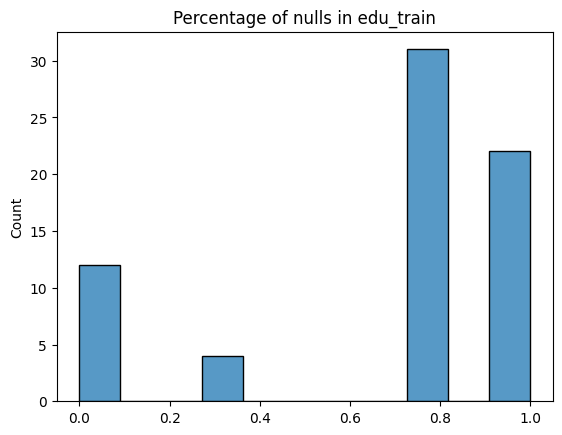

In [6]:
# there are a lot of nulls in the data
# we might as well just take the columns that have less than 50% nulls
# since we also have too many features to work with
sns.histplot(edu_train.isnull().sum(axis=0) / edu_train.shape[0])
plt.title("Percentage of nulls in edu_train")
plt.show()

['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'Q08', 'Q14']


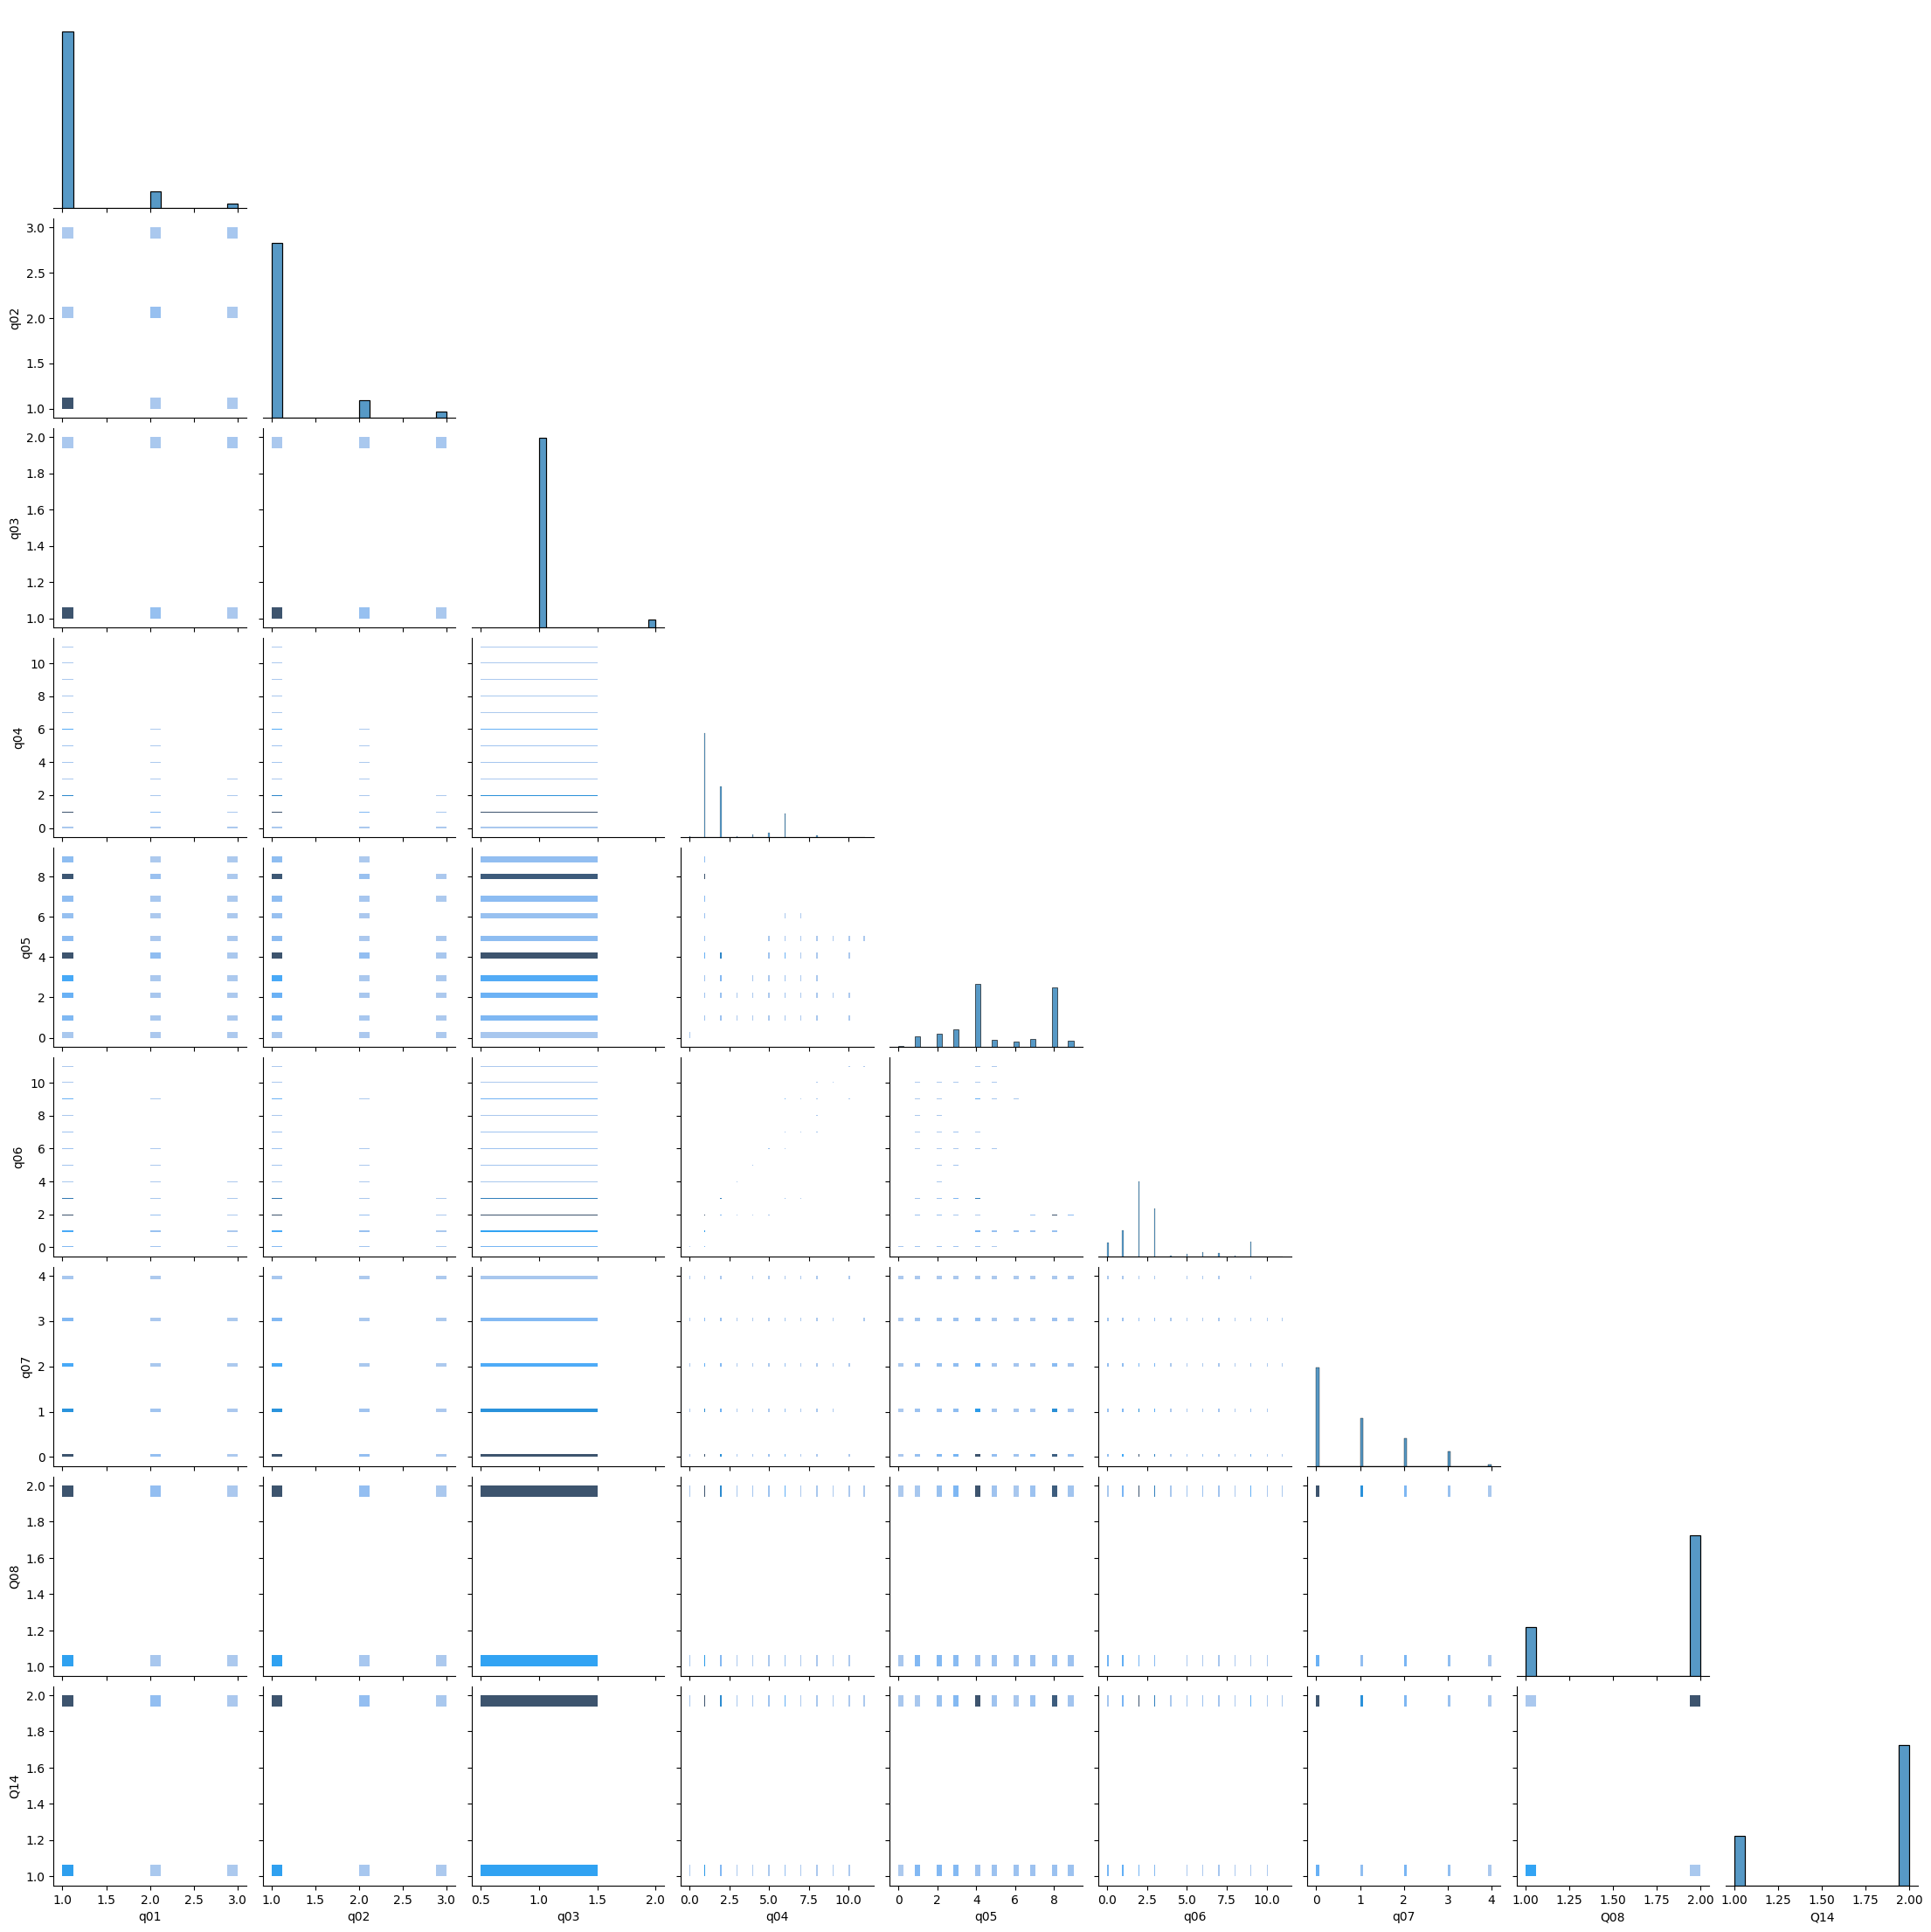

In [7]:
# they look pretty random to me, except for q4 and q6
# q4 and q6 are both related to education level, so it makes sense that they are correlated:
# q4) What is the highest grade [Name] have completed in school? In which level?
# q6) What is the highest diploma [Name] have attained?
threshold = 0.2
edu_selected_columns = edu_train.isnull().sum(axis=0) / edu_train.shape[0] < threshold
edu_selected_columns = edu_selected_columns[edu_selected_columns].index.tolist()

# they don't seem to have correlations, so I'm removing them from the plot for clarity
edu_selected_columns.remove("psu")
edu_selected_columns.remove("hh")
edu_selected_columns.remove("idcode")

sns.pairplot(edu_train[edu_selected_columns], kind="hist", corner=True)
print(edu_selected_columns)

In [8]:
# q1) Can [Name] read the newspaper?
# q2) Can [Name] write a one page personal letter?
# q3) Has [Name] ever attended school?
# q4, 5) What is the highest grade [Name] have completed in school? In which level?
# q6) What is the highest diploma [Name] have attained?
# q7) How many years of preschool did [Name] attend?
# q8) Did [Name] enroll or has you plans to enroll in school this academic year?
# q14) Did [NAME] enroll in the past academic year?

# q1-3 are somewhat related to each other (about their level of literacy)
# also q3 can terminate the survey if the answer is no. We might consider removing it too.

# q4 indicates most attended ["8 OR 9  YEARS" SCHOOL] or [GYMNAZIUM(SECONDARY GENERAL)]
# q5 range differs as it depends on q4, might consider removing it

# q7 appears like a 1/x distribution

# q8 & 14 these two appears to be closely related, the ones that didn't enroll in the past year are likely to not enroll in the current year

### The Household Data


In [9]:
house_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24001 entries, 0 to 24000
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   psu     24001 non-null  int64  
 1   hh      24001 non-null  int64  
 2   idcode  24001 non-null  int64  
 3   hhid    24001 non-null  int64  
 4   q02     24001 non-null  int64  
 5   q03     24001 non-null  int64  
 6   q04     24001 non-null  int64  
 7   q05y    24001 non-null  int64  
 8   q05m    24001 non-null  int64  
 9   q06     20465 non-null  float64
 10  q07     12148 non-null  float64
 11  q08     11761 non-null  float64
 12  q09     24001 non-null  int64  
 13  q10     24001 non-null  int64  
 14  q11     24001 non-null  int64  
 15  q12     11728 non-null  float64
 16  q13     12273 non-null  float64
 17  q14     12273 non-null  float64
 18  q15     6386 non-null   float64
 19  q16     5887 non-null   float64
 20  q17     24001 non-null  int64  
 21  q18     10697 non-null  float64
 22

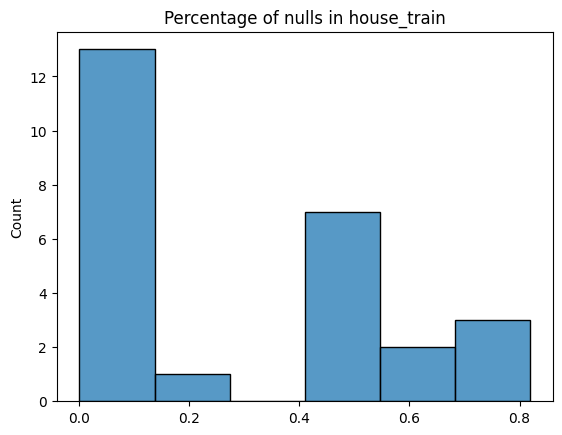

In [10]:
# Again, there are a lot of nulls in the data
# we might as well just take the columns that have less than 50% nulls
# since we also have too many features to work with
sns.histplot(house_train.isnull().sum(axis=0) / house_train.shape[0])
plt.title("Percentage of nulls in house_train")
plt.show()

['q02', 'q03', 'q04', 'q05y', 'q05m', 'q06', 'q09', 'q10', 'q11', 'q17']


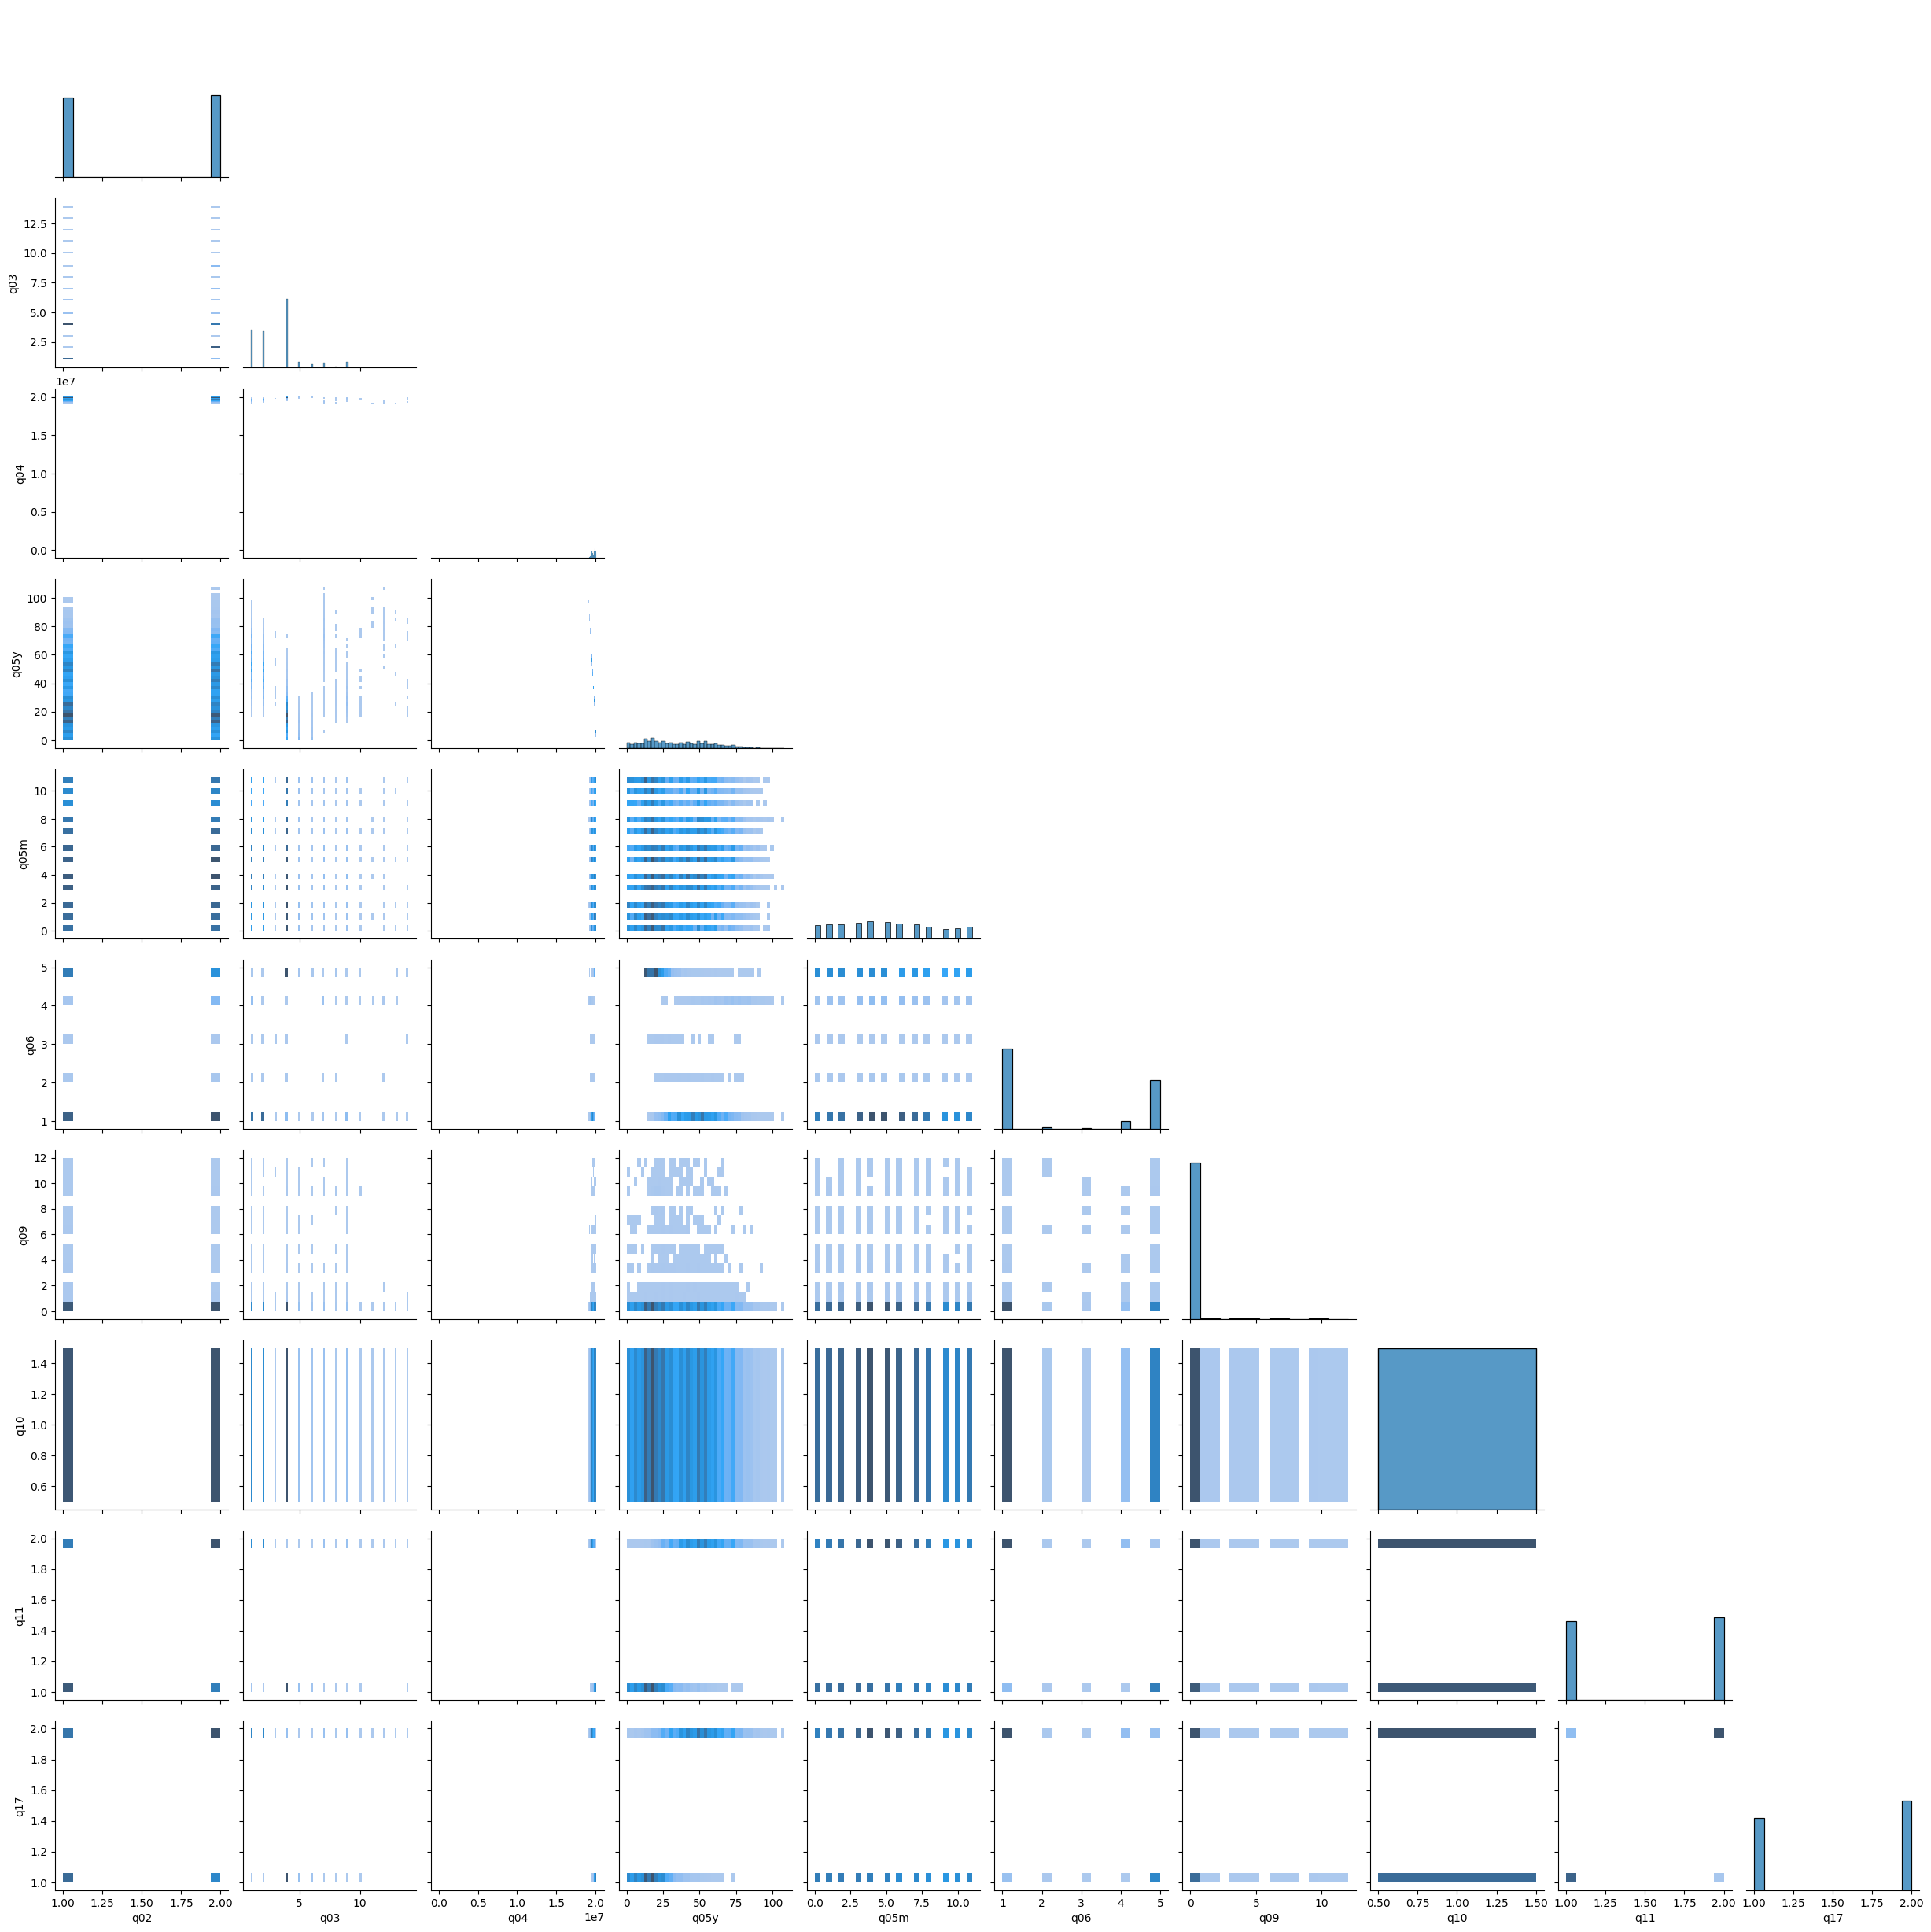

In [11]:
# same as edu_train
threshold = 0.2
house_selected_columns = (
    house_train.isnull().sum(axis=0) / house_train.shape[0] < threshold
)
house_selected_columns = house_selected_columns[house_selected_columns].index.tolist()

# they don't seem to have correlations, so I'm removing them from the plot for clarity
house_selected_columns.remove("psu")
house_selected_columns.remove("hh")
house_selected_columns.remove("hhid")  # this is just combination of psu and hh
house_selected_columns.remove("idcode")

sns.pairplot(house_train[house_selected_columns], kind="hist", corner=True)
print(house_selected_columns)

In [12]:
# q2) SEX
# q3) RELATIONSHIP TO HEAD:
# q4) DATE OF BIRTH:
# q5) How old is [NAME]?
# q6) What is the present marital status of [NAME]?
# q9) For how many months during the past 12 months (since MONTH/ YEAR) has he/she been away from this household?
# q10) Household Member Present?
# q11) Does the natural mother of [NAME] live in this household now?
# q17) Does the natural father of [NAME] live in this household now?

# q6 & (q11 | q17) somewhat related, if married then the parents are likely to not live in the same household
# q9 most people have just haven't left their household in the past 12 months
# q10 only 1 value... might consider removing it
# q11 & q17 are related to each other, if one is true, the other is likely to be true too

### Combining


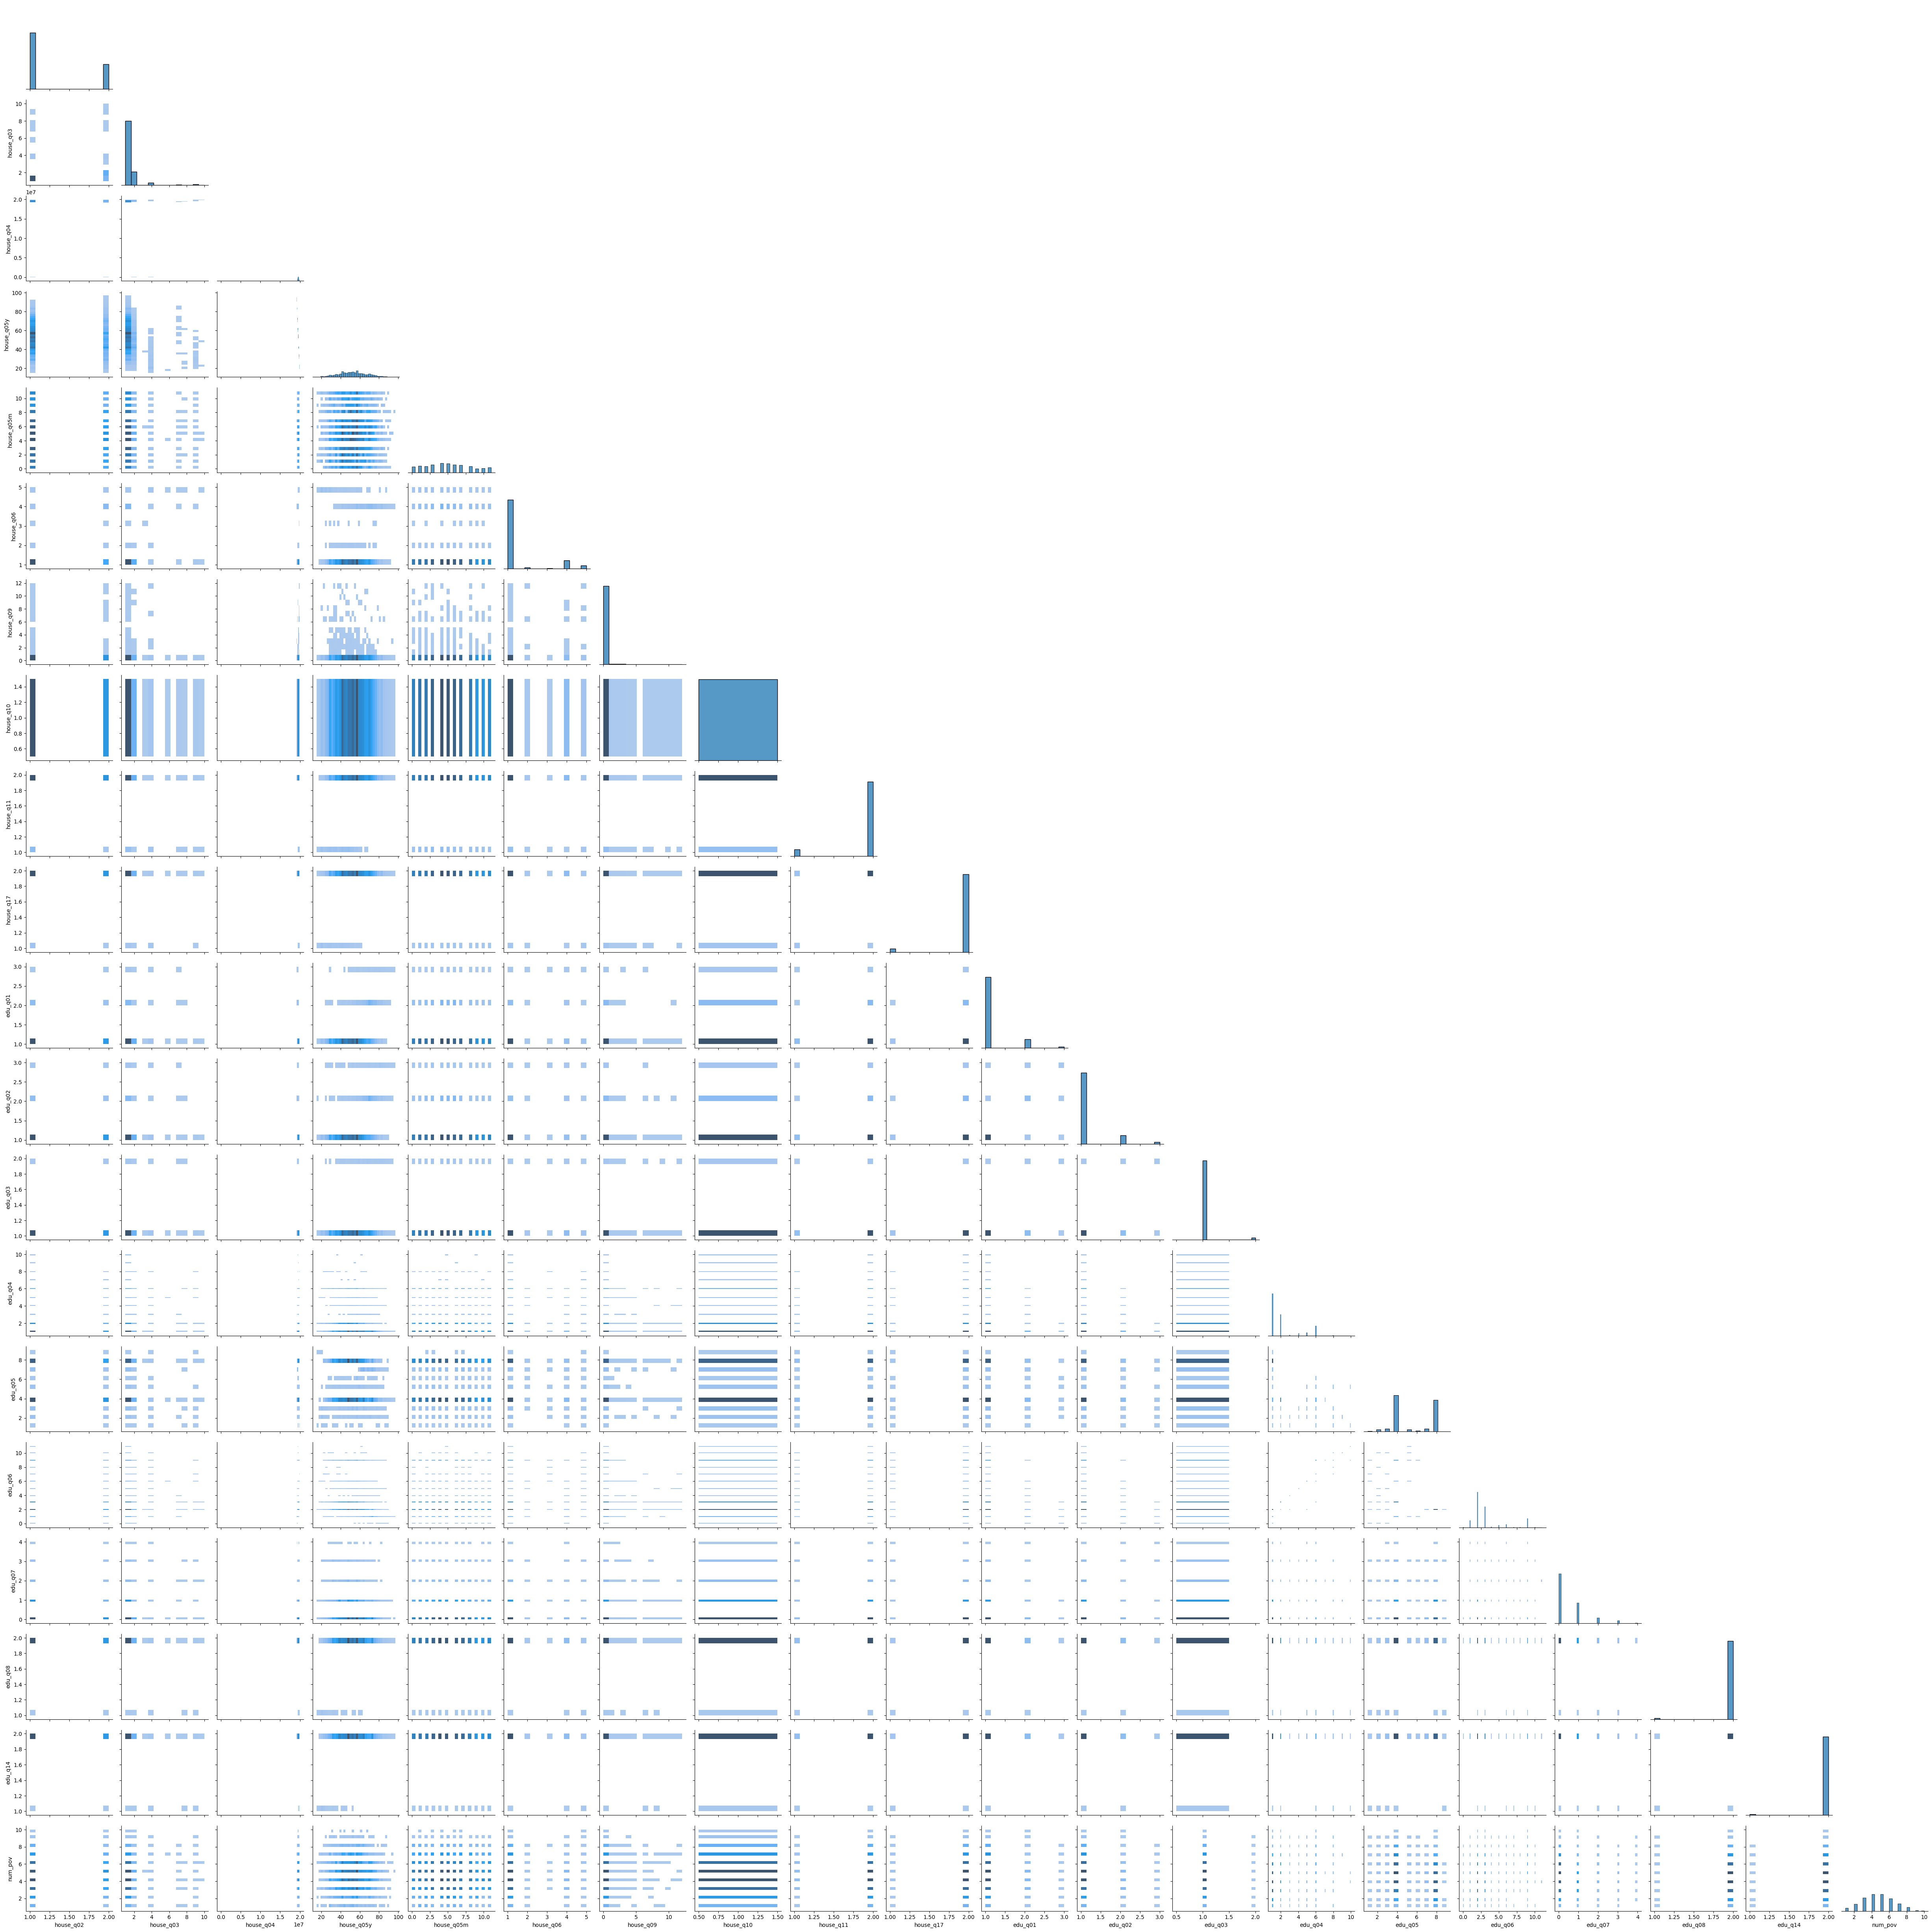

In [13]:
# now some pairplots for the combined data

doi = combined_train_with_num_pov[
    [HOUSE_PREFIX + column.lower() for column in house_selected_columns]
    + [EDU_PREFIX + column.lower() for column in edu_selected_columns]
    + ["num_pov"]
]
sns.pairplot(doi, kind="hist", corner=True)

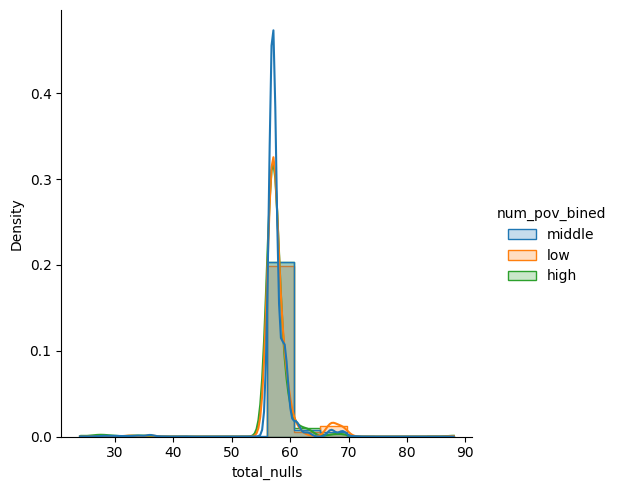

In [14]:
null_data = pd.DataFrame(
    np.column_stack(
        [
            combined_train_with_num_pov.isnull().to_numpy().sum(axis=1),
            combined_train_with_num_pov.loc[
                :, combined_train_with_num_pov.columns.str.startswith("house")
            ]
            .isnull()
            .to_numpy()
            .sum(axis=1),
            combined_train_with_num_pov.loc[
                :, combined_train_with_num_pov.columns.str.startswith("edu")
            ]
            .isnull()
            .to_numpy()
            .sum(axis=1),
            combined_train_with_num_pov["num_pov"],
            # pd.cut(
            #     combined_train_with_num_pov["num_pov"].astype(int),
            #     bins=[0, 2, 5, 8, 10],
            #     labels=["low", "mid-low", "mid-high", "high"],
            # ),
            pd.cut(
                combined_train_with_num_pov["num_pov"].astype(int),
                bins=[0, 2, 6, 10],
                labels=["low", "middle", "high"],
            ),
            # np.where(
            #     (combined_train_with_num_pov["num_pov"].astype(int) >= 3)
            #     & (combined_train_with_num_pov["num_pov"].astype(int) <= 8),
            #     "middle",
            #     "outlier",
            # ),
        ]
    ),
    columns=["total_nulls", "house_nulls", "edu_nulls", "num_pov", "num_pov_bined"],
)

# Ensure that the columns are numeric
null_data["total_nulls"] = pd.to_numeric(null_data["total_nulls"])
null_data["house_nulls"] = pd.to_numeric(null_data["house_nulls"])
null_data["edu_nulls"] = pd.to_numeric(null_data["edu_nulls"])
null_data["num_pov"] = pd.to_numeric(null_data["num_pov"])

# similar null distributions across the poverty levels...
sns.displot(
    null_data,
    x="total_nulls",
    hue="num_pov_bined",
    stat="density",
    common_norm=False,
    kde=True,
    element="step",
)

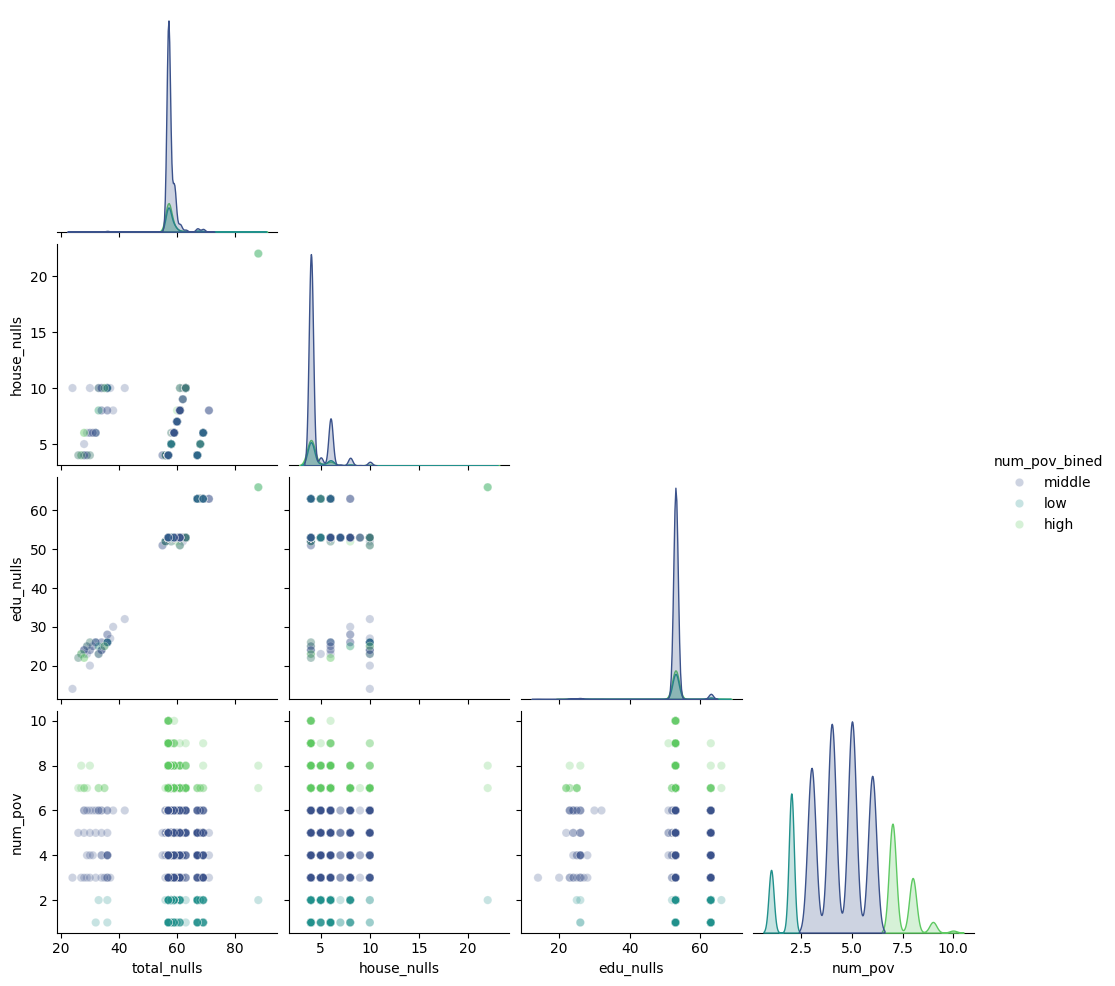

In [15]:
sns.pairplot(
    null_data,
    corner=True,
    plot_kws={"alpha": 0.25},
    hue="num_pov_bined",
    palette="viridis",
)

<Axes: xlabel="('num_pov', 'count')", ylabel="('num_pov', 'std')">

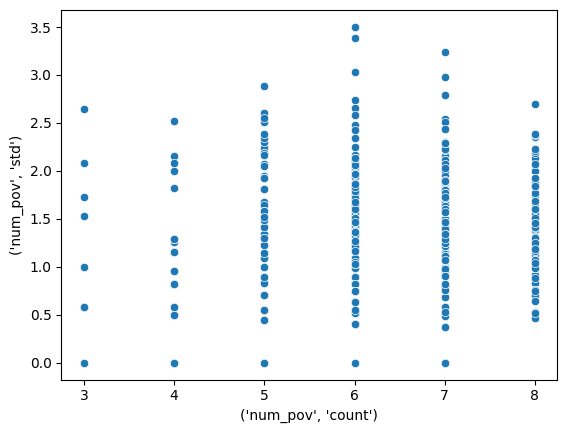

In [16]:
combined_train_with_num_pov[["psu", "hh", "idcode"]] = (
    combined_train_with_num_pov["psu_hh_idcode"].str.split("_", expand=True).astype(int)
)

by_psu_stats = (
    combined_train_with_num_pov[["psu", "num_pov"]]
    .groupby("psu")
    .agg(["mean", "count", "std"])
)
# by_hh_stats = combined_train_with_num_pov[["psu", "hh", "num_pov"]].groupby(["psu", "hh"]).agg(["mean", "count", "std"])
# by_psu_stats.describe()

sns.scatterplot(data=by_psu_stats, x=("num_pov", "count"), y=("num_pov", "std"))

In [17]:
# select those rows with 0 std
zero_std_psus = by_psu_stats[by_psu_stats[("num_pov", "std")] == 0]
zero_std_psus.columns = ["num_pov_mean", "num_pov_count", "num_pov_std"]
zero_std_psus

,num_pov_mean,num_pov_count,num_pov_std
psu,,,
75,3.0,7,0.0
97,2.0,3,0.0
232,4.0,4,0.0
293,2.0,7,0.0
490,7.0,7,0.0
511,6.0,7,0.0
580,1.0,5,0.0
581,1.0,6,0.0
588,1.0,7,0.0


In [18]:
# count number of rows with 0 std in test set
combined_test[["psu", "hh", "idcode"]] = (
    combined_test["psu_hh_idcode"].str.split("_", expand=True).astype(int)
)

psu_zero_std = zero_std_psus.index.to_numpy()
psu_zero_std_test = combined_test[combined_test["psu"].isin(psu_zero_std)].shape[0]
psu_zero_std_test

33

In [19]:
# select those rows with 0 std in predictions set
import os


predictions = pd.read_csv(os.path.join(PREDICTIONS_DIR, "elasticnet-logistic-1.csv"))
predictions[["psu", "hh", "idcode"]] = (
    predictions["psu_hh_idcode"].str.split("_", expand=True).astype(int)
)
roi = predictions[predictions["psu"].isin(psu_zero_std)]
roi["predicted_pov"] = (
    roi.loc[:, roi.columns.str.startswith("subjective_poverty")]
    .idxmax(axis=1)
    .str.split("_")
    .str[-1]
    .astype(int)
)
combined_roi = pd.merge(roi, zero_std_psus, on="psu", how="left")[
    ["psu", "num_pov_mean", "num_pov_count", "num_pov_std", "predicted_pov"]
]
(combined_roi["predicted_pov"] - combined_roi["num_pov_mean"]).abs().mean()

/var/folders/92/lv5lwsyj6pq0h_8d0gm14m680000gn/T/ipykernel_62505/2505162241.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi["predicted_pov"] = (


np.float64(2.303030303030303)

In [ ]:
from sklearn.metrics import log_loss


zero_std_dummies = pd.get_dummies(zero_std_psus["num_pov_mean"].astype(int)).astype(int)
zero_std_dummies[[8, 9, 10]] = 0
roi_predicted_pov = roi.loc[
    :, roi.columns.str.startswith("subjective_poverty") | (roi.columns == "psu")
]
combined_roi = pd.merge(
    roi_predicted_pov, zero_std_dummies, left_on="psu", right_index=True
)
log_loss(combined_roi.iloc[:, -10:], roi_predicted_pov.iloc[:, :-1])

2.4595555259478266

In [78]:
low_prob = 0.0005
high_prob = 1 - 9 * low_prob
to_replace = combined_roi.iloc[:, -10:].astype(float)
to_replace.columns = Y_COLUMNS
to_replace[to_replace == 1] = high_prob
to_replace[to_replace == 0] = low_prob

predictions.update(to_replace)

generate_submission(predictions.loc[:, Y_COLUMNS], "elasticnet-logistic-1(manual mod)")

Submission file saved as elasticnet-logistic-1(manual mod)-1.csv
